In [1]:
!pip install fastai==0.7.0 --no-deps
!pip install torch==0.4.1 torchvision==0.2.1

!pip install anaconda bcolz
!pip install anaconda isoweek
!pip install anaconda pandas-summary

  Created wheel for anaconda: filename=anaconda-0.0.1.1-cp36-none-any.whl size=1883 sha256=3572d578f05fcfb6cb0af480f955a7658012f68dc9b83498e7055380454c24cf
  Stored in directory: /Users/ilonakulikovskikh/Library/Caches/pip/wheels/d5/0e/c7/c65ff914fe711a32210656cf0c8d9f28041d78bff409ad96d0
Successfully built anaconda


In [2]:
#imports
import torch
from bokeh.plotting import figure, show, output_notebook, save, output_file

from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource
output_notebook()

#fastai related imports
import fastai
from fastai.learner import *
from fastai.column_data import *
import seaborn as sns
import sklearn.metrics as metrics

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

torch.cuda.is_available()

Loading BokehJS ...

/Users/ilonakulikovskikh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


False

In [3]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

using device: cpu


In [4]:
print(torch.__version__)

0.4.1


In [5]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [9]:
path='/content/drive/My Drive/Colab Notebooks/' #path to the dataset
data = pd.read_csv(f'{path}case5_train.csv')
print(data.head())
test = pd.read_csv(f'{path}case5_validation.csv')
print(test.head())

data = data[['cmpd_id', 'target_id', 'pKd']] #dropping cells .. not needed for this study
print(len(data))

test = test[['cmpd_id', 'target_id', 'pKd']] #dropping cells .. not needed for this study
print(len(test))

   Unnamed: 0        cmpd_id target_id  ...  Q9Z1T6  O00763  Q8IZX4
0           1  CHEMBL1232461    P25440  ...   0.128   0.052   0.122
1           2  CHEMBL1232461    O60885  ...   0.221   0.052   0.083
2          23  CHEMBL3139629    Q00987  ...   0.094   0.057   0.063
3          94    CHEMBL57481    P55201  ...   0.166   0.041   0.146
4         128  CHEMBL1957266    O60885  ...   0.221   0.052   0.083

[5 rows x 407 columns]
   Unnamed: 0        cmpd_id target_id  ...  Q9Z1T6  O00763  Q8IZX4
0          10  CHEMBL3645119    P52333  ...   0.199   0.150   0.154
1          11  CHEMBL3645119    P43405  ...   0.094   0.082   0.117
2          13  CHEMBL3645119    P23458  ...   0.181   0.181   0.145
3          15  CHEMBL3645119    O60674  ...   0.108   0.149   0.158
4          91  CHEMBL3645120    P52333  ...   0.199   0.150   0.154

[5 rows x 407 columns]
6450
7336


In [10]:
data.shape, test.shape 


((6450, 3), (7336, 3))

In [11]:
combined = pd.concat([data, test])
combined.head()

,cmpd_id,target_id,pKd
0,CHEMBL1232461,P25440,7.000000
1,CHEMBL1232461,O60885,7.187087
2,CHEMBL3139629,Q00987,6.301030
3,CHEMBL57481,P55201,3.769551
4,CHEMBL1957266,O60885,7.468521


In [12]:
cats = ['cmpd_id', 'target_id']
for c in cats:
    combined[c] = combined[c].astype('category').cat.codes

combined.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13786 entries, 0 to 7335
Data columns (total 3 columns):
cmpd_id      13786 non-null int16
target_id    13786 non-null int16
pKd          13786 non-null float64
dtypes: float64(1), int16(2)
memory usage: 269.3 KB


In [13]:
cat_sz = [(c, len(combined[c].unique())) for c in cats]
cat_sz

[('cmpd_id', 789), ('target_id', 442)]

In [14]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(789, 50), (442, 50)]

In [15]:
data = combined[:len(data)]
test = combined[len(data):]

min_rating,max_rating = data.pKd.min(),data.pKd.max()
min_rating,max_rating

(1.80687540164554, 10.698970004336)

# Collaborative filtering using pytorch and fastai

In [0]:
class ColumnarDataset(Dataset):
    def __init__(self, cats, conts, y):
        n = len(cats[0]) if cats else len(conts[0])
        self.cats = np.stack(cats, 1).astype(np.int64) if cats else np.zeros((n,1))
        self.conts = np.stack(conts, 1).astype(np.float32) if conts else np.zeros((n,1))
        self.y = np.zeros((n,1)) if y is None else y.values # THIS LINE IS CHANGED FROM y[:, None]
        
    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.y[idx]]

    @classmethod
    def from_data_frames(cls, df_cat, df_cont, y=None):
        cat_cols = [c.values for n,c in df_cat.items()]
        cont_cols = [c.values for n,c in df_cont.items()]
        return cls(cat_cols, cont_cols, y)

    @classmethod
    def from_data_frame(cls, df, cat_flds, y=None):
        return cls.from_data_frames(df[cat_flds], df.drop(cat_flds, axis=1), y)
      

class ColumnarModelData(ModelData):
    def __init__(self, path, trn_ds, val_ds, bs, test_ds=None, shuffle=True):
        test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=1) if test_ds is not None else None
        super().__init__(path, DataLoader(trn_ds, bs, shuffle=shuffle, num_workers=1),
            DataLoader(val_ds, bs*2, shuffle=False, num_workers=1), test_dl)

    @classmethod
    def from_arrays(cls, path, val_idxs, xs, y, bs=64, test_xs=None, shuffle=True):
        ((val_xs, trn_xs), (val_y, trn_y)) = split_by_idx(val_idxs, xs, y)
        test_ds = PassthruDataset(*(test_xs.T), [0] * len(test_xs)) if test_xs is not None else None
        return cls(path, PassthruDataset(*(trn_xs.T), trn_y), PassthruDataset(*(val_xs.T), val_y),
                   bs=bs, shuffle=shuffle, test_ds=test_ds)

    @classmethod
    def from_data_frames(cls, path, trn_df, val_df, trn_y, val_y, cat_flds, bs, test_df=None):
        test_ds = ColumnarDataset.from_data_frame(test_df, cat_flds) if test_df is not None else None
        return cls(path, ColumnarDataset.from_data_frame(trn_df, cat_flds, trn_y),
                    ColumnarDataset.from_data_frame(val_df, cat_flds, val_y), bs, test_ds=test_ds)

    @classmethod
    def from_data_frame(cls, path, val_idxs, df, y, cat_flds, bs, test_df=None):
        ((val_df, trn_df), (val_y, trn_y)) = split_by_idx(val_idxs, df, y)
        return cls.from_data_frames(path, trn_df, val_df, trn_y, val_y, cat_flds, bs, test_df=test_df)

    def get_learner(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                    y_range=None, use_bn=False, **kwargs):
        model = MixedInputModel(emb_szs, n_cont, emb_drop, out_sz, szs, drops, y_range, use_bn)
        return StructuredLearner(self, StructuredModel(to_gpu(model)), opt_fn=optim.Adam, **kwargs)

In [17]:
n_factors = emb_szs[0][1] #how big embedding matrix we want
n_users = int(cat_sz[0][1])
n_movies = int(cat_sz[1][1])
print(n_factors)
print(n_users)
print(n_movies)

#val_idxs = get_cv_idxs(len(data)) #20% validation 

50
789
442


In [0]:
from sklearn.model_selection import train_test_split

x = data.drop(['pKd'],axis=1)
y = data['pKd'].astype(np.float32) #pytorch requires every input to be of type float32

trn_df, val_df, trn_y, val_y = train_test_split(x, y, test_size=0.2, random_state=1)


In [0]:
data = ColumnarModelData.from_data_frames(path, trn_df, val_df, trn_y.astype('float'), val_y.astype('float'), cats, 64, test_df = test[cats])

#md = ColumnarModelData.from_data_frames('/tmp', trn_df, val_df, trn_y.astype('int'), val_y.astype('int'), cats, 128, test_df=test[cats])

In [0]:
xmb,ymb,zmb = next(iter(data.trn_dl)) #storing a mini-batch


In [24]:
data.test_dl


### Defining the model class

In [0]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf) #creating embedding matrix of a given size
    e.weight.data.uniform_(-0.01,0.01) #initializing values within embedding matrix.Kaiming He initialization 
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            emb_szs[0], emb_szs[1], (cat_sz[0][1],1), (cat_sz[1][1],1)
        ]] #defining embedding matrix and bias matrix
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        um = (self.u(users)* self.m(movies))#.sum(1)  #dot product of embedding vectors
        print(um.size())
        res = um.sum(1) + self.ub(users).squeeze() + self.mb(movies).squeeze() #addition of bias
        #res = torch.unsqueeze(res,1)
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating
        #torch.unsqueeze(res, 1)
        #res.view(-1,-1)
        return res

In [26]:
model = EmbeddingDotBias(n_users, n_movies).cuda()
wd=2e-4 #weight decay

opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

fit(model, data, 10, opt, F.mse_loss)

 83%|████████▎ | 67/81 [00:00<00:00, 127.39it/s, loss=0.608]torch.Size([40, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([10, 50])
epoch      trn_loss   val_loss   
    0      0.606822   0.508872  
 90%|█████████ | 73/81 [00:00<00:00, 136.17it/s, loss=0.497]torch.Size([40, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([10, 50])
    1      0.501437   0.512797  
 86%|████████▋ | 70/81 [00:00<00:00, 111.56it/s, loss=0.434]torch.Size([40, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])

[0.39682330429091933]

In [27]:
preds_trn = predict(model,data.trn_dl)
preds_val = predict(model,data.val_dl)
preds_test = predict(model,data.test_dl)


torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([6

In [28]:
set_lrs(opt, 1e-3)
fit(model, data, 50, opt, F.mse_loss)

 95%|█████████▌| 77/81 [00:00<00:00, 123.69it/s, loss=0.0648]torch.Size([40, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([10, 50])
epoch      trn_loss   val_loss   
    0      0.069034   0.395363  
 99%|█████████▉| 80/81 [00:00<00:00, 111.44it/s, loss=0.0647]torch.Size([40, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([10, 50])
    1      0.065629   0.394034  
 83%|████████▎ | 67/81 [00:00<00:00, 124.51it/s, loss=0.0658]torch.Size([40, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 5

[0.38848646560380623]

In [29]:
preds_trn = predict(model,data.trn_dl)
preds_val = predict(model,data.val_dl)
preds_test = predict(model,data.test_dl)


torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([6

1.262626538870325
0.6232868301706757
0.9032067175651138


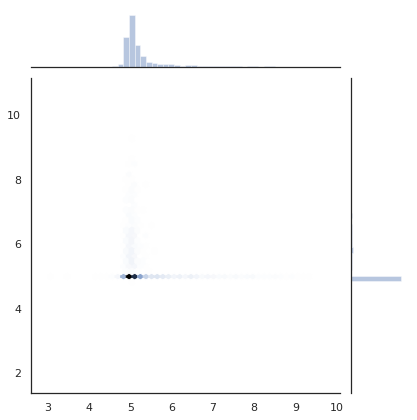

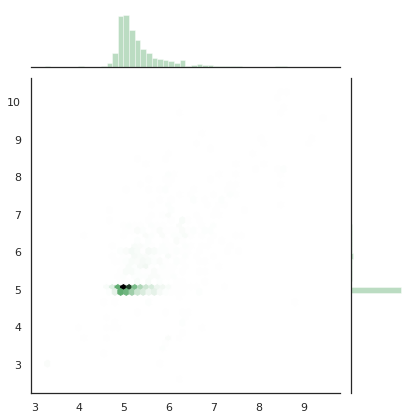

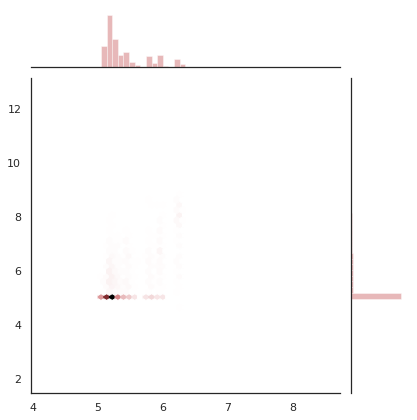

In [30]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
sns.set(style="white", color_codes=True)


preds = [preds_trn, preds_val, preds_test]

data_y = [data.trn_y, data.val_y, test.pKd.values]

sns.jointplot(preds[0], data_y[0], kind='hex', color="b", stat_func=None);
print(math.sqrt(metrics.mean_squared_error(preds[0], data_y[0])))
#df_trn = pd.DataFrame({'predicted':preds_trn, 'actual':data.trn_y})
#print(df_trn)

sns.jointplot(preds[1], data_y[1], kind='hex', color="g",stat_func=None);
print(math.sqrt(metrics.mean_squared_error(preds[1], data_y[1])))

sns.jointplot(preds[2], data_y[2], kind='hex', color="r",stat_func=None);
print(math.sqrt(metrics.mean_squared_error(preds[2], data_y[2])))




In [0]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh) 
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        res = F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5
        res = torch.squeeze(res,1)
        return res

In [0]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-4, weight_decay=wd)

In [35]:
fit(model, data, 500, opt, F.mse_loss)

epoch      trn_loss   val_loss   
    0      0.329154   0.463375  
    1      0.324079   0.460775  
    2      0.3149     0.459356  
    3      0.326367   0.460067  
    4      0.334705   0.460685  
    5      0.32615    0.461394  
    6      0.324052   0.461782  
    7      0.33587    0.459969  
    8      0.33283    0.459948  
    9      0.320865   0.461575  
    10     0.343155   0.46236   
    11     0.333877   0.463564  
    12     0.325966   0.463674  
    13     0.329129   0.463711  
    14     0.321592   0.463942  
    15     0.320723   0.464047  
    16     0.30894    0.464352  
    17     0.317151   0.462014  
    18     0.336815   0.462269  
    19     0.32227    0.46236   
    20     0.331481   0.462211  
    21     0.337217   0.46281   
    22     0.339561   0.462511  
    23     0.338515   0.462426  
    24     0.326457   0.462511  
    25     0.316805   0.463909  
    26     0.336146   0.462721  
    27     0.325001   0.462155  
    28     0.32317    0.462321  
    29   

[0.466685428083405]

In [0]:
preds_trn = predict(model,data.trn_dl)
preds_val = predict(model,data.val_dl)
preds_test = predict(model,data.test_dl)


1.2030218937682784
0.6831437854653416
0.9588765890920166


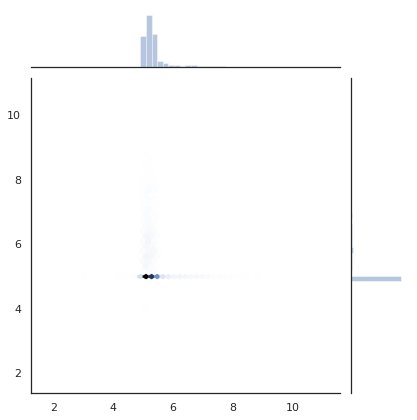

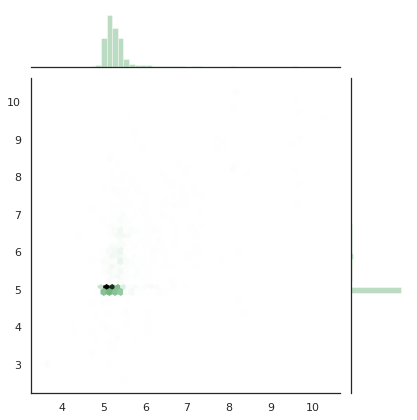

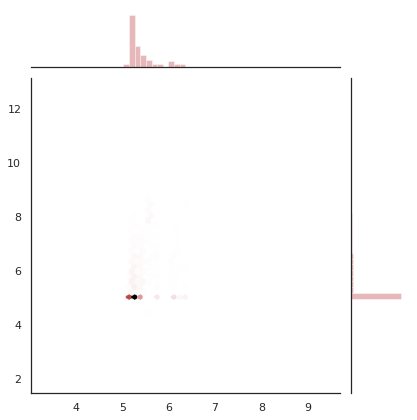

In [37]:
preds = [preds_trn, preds_val, preds_test]

data_y = [data.trn_y, data.val_y, test.pKd.values]

sns.jointplot(preds[0], data_y[0], kind='hex', color="b", stat_func=None);
print(math.sqrt(metrics.mean_squared_error(preds[0], data_y[0])))
#df_trn = pd.DataFrame({'predicted':preds_trn, 'actual':data.trn_y})
#print(df_trn)

sns.jointplot(preds[1], data_y[1], kind='hex', color="g",stat_func=None);
print(math.sqrt(metrics.mean_squared_error(preds[1], data_y[1])))

sns.jointplot(preds[2], data_y[2], kind='hex', color="r",stat_func=None);
print(math.sqrt(metrics.mean_squared_error(preds[2], data_y[2])))


